In [1]:
# ensure classes imported from .py files are dynamically updated
%load_ext autoreload
%autoreload 2

# plot matplots nicely
%matplotlib inline

In [81]:
# import from pythin packages
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import cmocean
from datetime import datetime, date, timedelta

# import from pre-built data classes
from data_handler import *
from steric_height import StericHeight
from plotting_fns import PlottingFns as pfns
from region import Region
from utils import Utils as utls

pfns = pfns()

In [3]:
# load dynamic ocean topography data from class
dot = DOT().ds.dot
lwe = GRACE(from_file=False).ds.lwe_thickness
msl = ERA5().ds.msl

# set up stweric height
sha = StericHeight(ssh_ref='DOT',
                   ssh=dot,
                   lwe=lwe,
                   msl=msl,
                  ).get_sha(startend=[dot.time[0],dot.time[-1]])#[pd.Timestamp(2002,7,1),pd.Timestamp(2017,6,1)])

/nfs/b0133/eejco/miniconda3/envs/sha-env/lib/python3.10/site-packages/xarray/coding/times.py:251: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


In [4]:
soi_fname = '../data/SOI/soi_noaa.csv'
data = pd.read_csv(soi_fname,header=None,usecols=[1,2,3,4,5,6,7,8,9,10,11,12]).to_numpy()
years = np.repeat(pd.read_csv(soi_fname,header=None,usecols=[0]).to_numpy(),12)
months = np.tile(np.arange(1,13),len(data))
time = [pd.Timestamp(y,m,1) for y,m in zip (years,months)]
data = data.reshape(np.size(data))
soi = xr.DataArray(data,coords={'time': time})


In [5]:
sha_data = sha.sha
soi = soi.sel(time=slice(sha_data.time[0],sha_data.time[-1]))


In [123]:
def composite_analysis(idx_data,sha_data,limit,idx_name,label,title_text=None,vmax=3,lower_limit=None,background_data=None,background_label=None,leg_loc='upper right'):

    if lower_limit is None:
        lower_limit = -limit
        lower_fill_text = '-' + (title_text or str(limit))
    else:
        lower_fill_text = str(lower_limit)

    fill_text = title_text or str(limit)

    idx_positive = idx_data >= limit
    idx_negative = idx_data <= lower_limit

    spb = sha_data.sel(latitude=slice(-60,-50),longitude=slice(-130,-110)).mean(['latitude','longitude'])

    fig = plt.figure(figsize=(12,8))

    gs = fig.add_gridspec(2,2,height_ratios=[1,2])
    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, 0],projection=ccrs.SouthPolarStereo())
    ax3 = fig.add_subplot(gs[1, 1],projection=ccrs.SouthPolarStereo())

    ax=ax1
    if background_data is not None:
        ax.plot(background_data.time,background_data,color='#96ae8d',label=background_label)
    ax.plot(idx_data.time,idx_data,color='olive',label=label)
    ax.plot(idx_data.time,np.zeros_like(idx_data),color='#373e02')
    #ax.twinx().plot(spb.time,spb,color='g')
    ax.fill_between(idx_data.time, 0,5, where=idx_positive, alpha=0.4, facecolor='darkkhaki',label='+/- '+fill_text)
    ax.fill_between(idx_data.time,-5,0, where=idx_negative, alpha=0.4, facecolor='darkkhaki')
    ax.set_ylim([-5,5])
    ax.set_ylabel(idx_name)
    ax.legend(loc=leg_loc)
    ax.set_title('(a)',loc='left')
    ax.grid()

    sha_pos = sha_data.where(idx_positive,drop=True).mean('time')
    sha_neg = sha_data.where(idx_negative,drop=True).mean('time')
    #fig, axs = plt.subplots(1,2,figsize=(12,4),subplot_kw={'projection': ccrs.SouthPolarStereo()})
    axs=[ax2,ax3]
    pfns.sp(axs[0],sha_pos,cmap=cmocean.cm.balance,cbar='SHA (cm)',vmax=vmax,cbar_orientation='vertical',land_zorder=3)#title='POSITIVE ' + idx_name + ', (> ' + fill_text + ')')
    pfns.sp(axs[1],sha_neg,cmap=cmocean.cm.balance,cbar='SHA (cm)',vmax=vmax,cbar_orientation='vertical',land_zorder=3)#title='NEGATIVE ' + idx_name + ', (< '+ lower_fill_text + ')'
    ax2.set_title('(b)',loc='left')
    ax3.set_title('(c)',loc='left')
    ax2.text(40,-80,'+'+idx_name,transform=ccrs.PlateCarree(),size=15,c='#373e02',ha='center',bbox=dict(boxstyle="square",facecolor='darkkhaki',alpha=0.5))
    ax3.text(40,-80,'-'+idx_name,transform=ccrs.PlateCarree(),size=15,c='#373e02',ha='center',bbox=dict(boxstyle="square",facecolor='darkkhaki',alpha=0.5))


    fig.tight_layout()

    return fig




In [46]:
#composite_analysis(soi,sha.sha,soi.std(),'SOI (UNFILTERED)',r'$1\sigma$')

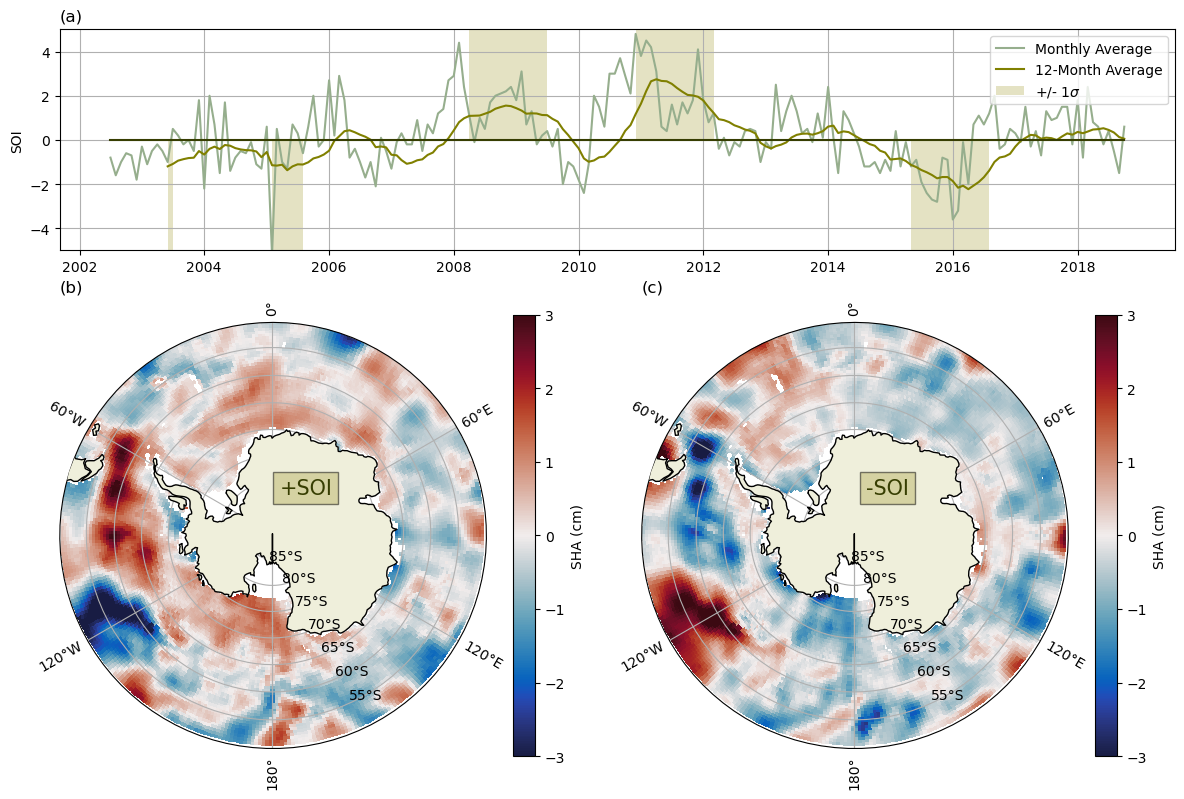

In [124]:
soi_roll = soi.rolling(time=12).mean('time')
soi_roll_mean = soi_roll.mean()
soi_roll_adjusted = soi_roll - soi_roll_mean
soi_fig = composite_analysis(soi_roll_adjusted,
                   sha.sha.rolling(time=12).mean('time'),
                   soi_roll_adjusted.std().item(),
                   'SOI',
                   '12-Month Average',
                   r'$1\sigma$',
                   background_data=soi,
                   background_label='Monthly Average')
soi_fig.savefig('plots/figure6.png',dpi=200,transparent=True,bbox_inches='tight')


In [116]:
sam=Index('SAM').da
sam = sam.sel(time=slice(sha.time[0],sha.time[-1]))

In [96]:
#composite_analysis(sam,sha.sha_grace_only,sam.std(),'SAM (UNFILTERED)',r'$1\sigma$')

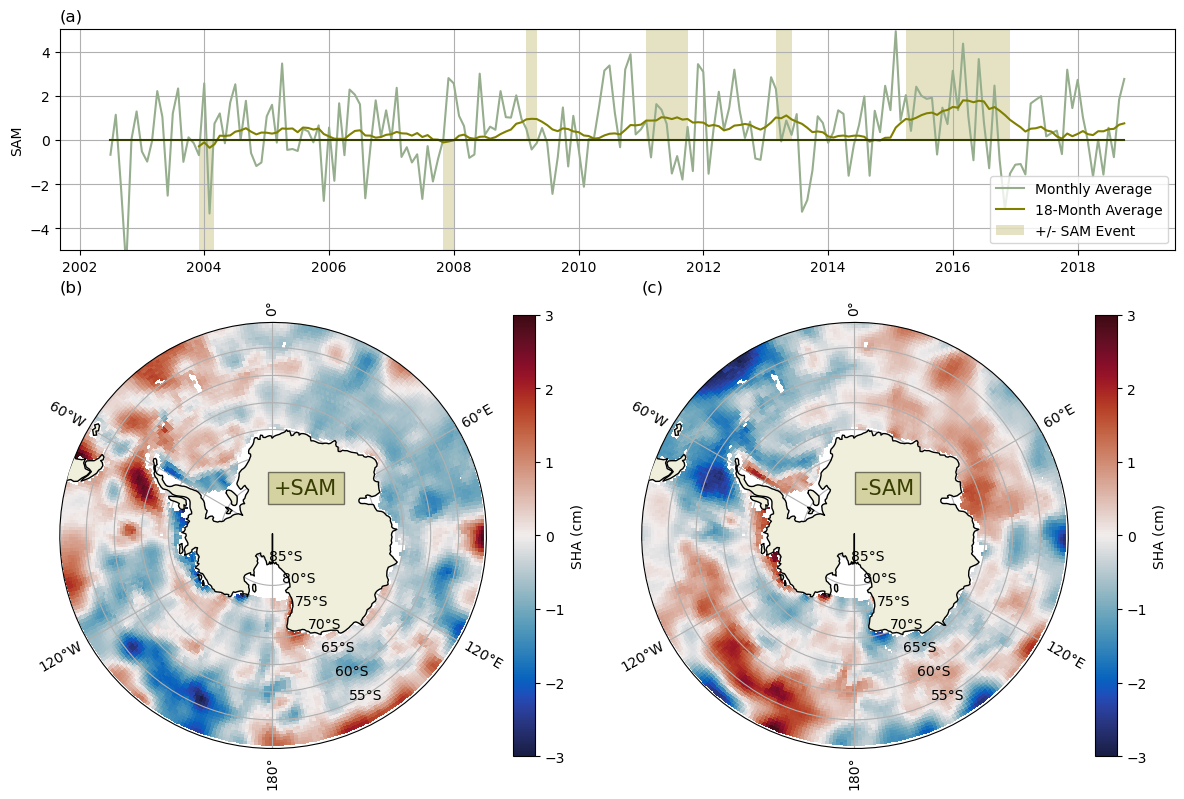

In [125]:
sam_fig=composite_analysis(sam.rolling(time=18).mean('time'),
                   sha.sha.rolling(time=18).mean('time'),
                   sam.rolling(time=18).mean('time').std() * 2,
                   'SAM',
                   '18-Month Average',
                   'SAM Event',#r'$2\sigma$',
                   lower_limit = 0,
                   background_data=sam,
                   background_label='Monthly Average',
                   leg_loc = 'lower right')
sam_fig.savefig('plots/figure7.png',dpi=200,transparent=True,bbox_inches='tight')
